In [1]:
import glob

#Numpy
import numpy as np
import scipy

#For image plotting
import skimage.io
import skimage.filters as sf
from skimage import io, measure, filters, transform, morphology

#Matplotlib plotting packages
import matplotlib.pyplot as plt

# For loading bars
from tqdm.notebook import tqdm as tqdm

import pandas as pd


In [2]:
def filter_mts(image, block_size=5, mask_size=5, yen=False):
    """
    Image processing for individual MT image file. Images are first normalized
    before applying local thresholding to correct for nonuniform image background.
    Global thresholding is then performed to obtain the thresholded image of
    putative microtubules. Further processing is performed where small breaks
    in filaments are reconnected again.
    """
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered

def border_clear(im_label, edge=3):
    """
    Remove objects within `edge` pixels from the image boundary

    Input
    -------
    im_label : labeled image where objects in the image are assigned positive integer value
    edge : maximum number of pixels that putative filament needs to be away from the image boundary to be rejected
    """
    im_border = np.copy(im_label)

    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    return im_border

def determine_count_nums(im_label):
    """
    Obtains maximum number of objects in the labeled image. Used to determine
    if background subtraction and thresholding must be performed on top of Niblack
    thresholding scheme.
    """
    unique, counts = np.unique(im_label, return_counts=True)

    return unique, counts

def remove_small(im_label, area_thresh=10):
    im_sized = np.copy(im_label)

    unique, counts = determine_count_nums(im_label)

    # Create dictionary except for 0 (background)
    dict_area = dict(zip(unique,counts))

    for label in unique:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
    
    return im_sized

def remove_circulars(im_label, eccen_thresh=0.8):
    im_eccen = im_label.copy()

    im_props = measure.regionprops_table(im_eccen,
                                        properties=['label','eccentricity'])
    df = pd.DataFrame(im_props)

    for n in np.unique(im_eccen):
        if df[df['label']==n]['eccentricity'].values < eccen_thresh:
            im_eccen[im_eccen==n] = 0

    return im_eccen

def are2lines(mt_segment, min_dist=9, min_angle=75):
    """
    Determine if putative microtubules are two microtubules. Uses
    Hough straight lines to determine if there are at least 2
    lines that can be drawn from the putative filament.
    
    Input
    -------
    mt_segment : (M, N), ndarray; cropped region about the putative
                 microtubule
    min_angle : int, minimum angle (in degrees) separating lines (default 75)
    
    Return
    -------
    len(angles)==2 : bool, determines whether there is a crossover
    """
    test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

    return len(angles)==2

def remove_line_crossovers(image, min_dist=9, min_angle=75, padding=3):
    """
    Removes microtubules that cross over in the images. 
    Input
    -------
    image : (M, N), ndarray; image from which MT crossovers are removed
    min_angle : int, minimum angle (in degrees) separating lines (default 30)
    padding : int, padding around cropped MT segments

    Return
    -------
    im_cleaned : (M, N), ndarray; image with MT crossovers removed
    """
    im_cleaned = image.copy()

    for n in np.unique(image)[1:]:
        x,y = np.where(image==n)
        mt_segment = image[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
        
        if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
            im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

    return im_cleaned

def process_mt_images(image, block_size=3, mask_size=3, count_thresh=200, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size)
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    # Determine if Yen thresholding background subtraction is necessary
    unique, _ = determine_count_nums(im_label)
    if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)
    im_internal = border_clear(im_label, edge=edge)
    im_sized = remove_small(im_internal, area_thresh=area_thresh)
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)

    return im_noxovers

## Import Images

In [3]:
#Import Stack
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/353/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP353_lowATPload_2min_1/images/'
included_frames = '*2023*.tif'
im_dir = file_path+file_folder+included_frames

im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

#Import Background
bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg_im = skimage.io.imread(im_dir).astype(np.int16)
bg_avg = np.average(bg_im)

## Check for anomalously bright pixels and remove

Check the maximum projection

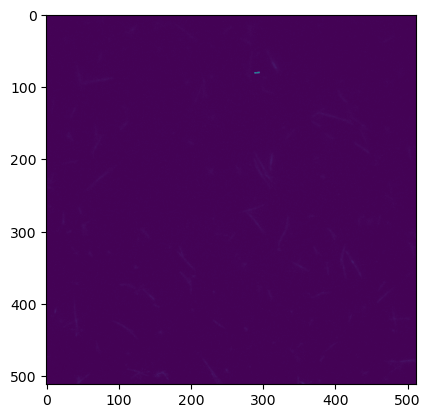

In [4]:
# Define a max projection
im_max = np.amax(im_stack, axis=0)
plt.imshow(im_max)

Yeah... that's way too bright. Remove the frame with the brightest pixel:

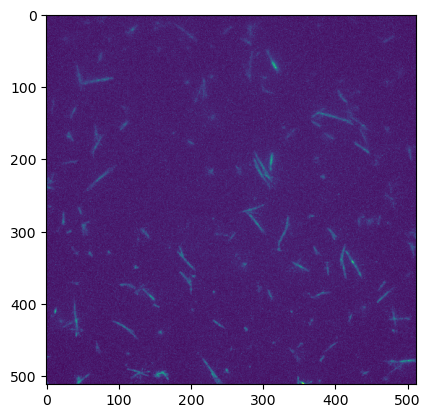

In [5]:
#Find the frame with the location of the brightest pixel
bright_frame = np.where(im_stack==im_max.max())[0][0]

#Exclude this frame
im_stack_rm = np.delete(im_stack, bright_frame, axis=0)

#Check the new max projection
plt.imshow(np.amax(im_stack_rm, axis=0))

Way better!

## Define Properties

In [6]:
pixel_size = 0.161 #um/pixel

block_size=3
mask_size=1
edge=3
area_thresh=10
min_dist=9
min_angle=75
padding=3

## Max Proj Function

In [7]:
## Func for segmenting max proj

def max_proj(stack, block_size=3, mask_size=1, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    #create the m=youaximum projection
    proj = np.amax(stack-bg_avg, axis=0)
    
    #Normalize the image
    image_norm = (proj - proj.min()) / (proj.max() - proj.min())
    
    #Niblack thresholding - think like text
    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size, k=0.001)
    
    #Otsu thresholding
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)
    
    #Create a mask
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)
    
    #Label each region
    im_filtered = im_closed.copy()
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    unique_regions, region_counts = np.unique(im_label, return_counts=True)
    
    #Remove border
    im_border = np.copy(im_label)
    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    im_internal = im_border

    # Remove small regions - Create dictionary except for 0 (background)
    dict_area = dict(zip(unique_regions,region_counts))
    im_sized = np.copy(im_internal)
    for label in unique_regions:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
            
    #Thin each region - preserve connectivity but strip away any padding on the outside to get "skeleton"s
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    
    #Remove crossovers
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)
    
    #Determine properties
    im_props = measure.regionprops_table(im_noxovers, proj,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
    df = pd.DataFrame(im_props)
    
    return im_noxovers, df

In [8]:
im_max, df_max = max_proj(im_stack_rm)

In [9]:
df_max

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter
0,16,22.767580,2.752238,21.437500,117.500000,-0.938592,0.992667,2,17.935029
1,11,15.068909,1.193254,18.727273,185.090909,0.931632,0.996860,3,11.485281
2,16,16.347927,3.968032,25.000000,282.750000,0.213149,0.970095,4,15.278175
3,7,9.547920,1.253761,23.142857,248.428571,-0.719604,0.991341,5,6.449747
4,8,11.330762,1.055380,28.875000,197.625000,0.840510,0.995653,6,7.863961
...,...,...,...,...,...,...,...,...,...
71,8,10.394146,1.860574,457.875000,350.875000,-0.804528,0.983849,102,7.449747
72,5,7.279216,0.879216,465.200000,339.000000,0.884096,0.992679,103,4.035534
73,7,8.853249,1.612321,475.000000,347.285714,0.450719,0.983277,105,6.449747
74,6,8.652106,0.834637,476.500000,381.166667,-0.664362,0.995336,106,5.242641


[Text(0, 0.0, '0.0'),
 Text(0, 0.25, '0.25'),
 Text(0, 0.5, '0.50'),
 Text(0, 0.75, '0.75'),
 Text(0, 1.0, '1.0')]

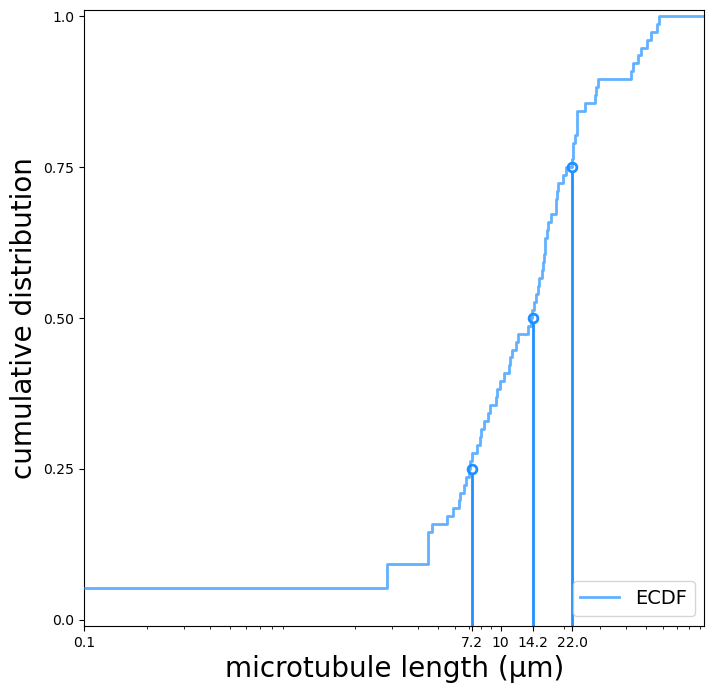

In [10]:
mt_length = np.sort((df_max['major_axis_length'].values))
ecdf = np.arange(1, len(mt_length)+1, 1) /len(mt_length)

q_25 = np.percentile(mt_length, 25)
q_50 = np.percentile(mt_length, 50)
q_75 = np.percentile(mt_length, 75)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.step(mt_length, ecdf, label='ECDF', color='dodgerblue', lw=2, zorder=4, alpha=0.7)

ax.scatter(q_25, 0.25, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_50, 0.50, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_75, 0.75, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)

ax.axvline(q_25, 0, 0.25, color='dodgerblue', lw=2)
ax.axvline(q_50, 0, 0.50, color='dodgerblue', lw=2)
ax.axvline(q_75, 0, 0.75, color='dodgerblue', lw=2)

ax.set_xlim([0.1,np.max(mt_length)])
ax.set_ylim([-0.01,1.01])
ax.set_xlabel('microtubule length (µm)', fontsize=20)
ax.set_ylabel('cumulative distribution', fontsize=20)
ax.legend(fontsize=14, loc=4)
ax.set_xscale('log')

ax.set_xticks([0.1, q_25, q_50, q_75, 10])
ax.set_xticklabels(['0.1', '%.1f' %q_25, '%.1f' %q_50, '%.1f' %q_75, '10'])

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.0', '0.25', '0.50', '0.75', '1.0'])

## Process single frame

## Generate Kymographs from max proj

390.5 0.8711096938321925 168.64285714285714 18.497202352471554 382 398
17


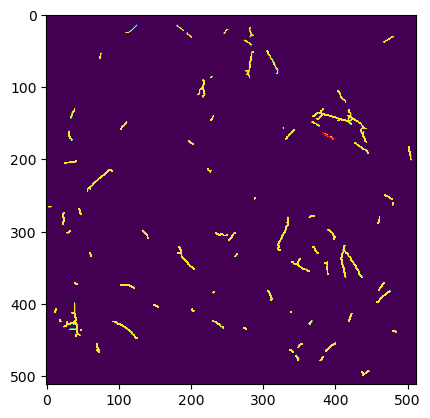

In [19]:
i=21
xc =  df_max.loc[i, 'centroid-1']
yc =  df_max.loc[i, 'centroid-0']
l =  df_max.loc[i, 'major_axis_length']
theta = -df_max.loc[i, 'orientation'] + (np.pi/2)
print(xc, np.cos(theta), yc, l, int(xc - np.abs(0.5*l*np.cos(theta))), int(xc + np.abs(0.5*l*np.cos(theta))))
xvals = np.arange(xc - np.abs(0.5*l*np.cos(theta)), xc + np.abs(0.5*l*np.cos(theta))).astype(int)
print(len(xvals))
test_line = (np.tan(theta)*xvals + (yc - np.tan(theta)*xc)).astype(int)

plt.imshow(im_max, vmin=0, vmax=1)
plt.plot(xvals, test_line, color='r', lw=1)
#plt.scatter(xc, yc, color='r')
# # plt.imshow(max_im[200:300, 0:500])
# stack[0][test_line[0]:test_line[-1], xvals[0]:xvals[-1]]
# mykymo = []
# for im in stack:
#     ls=[]
#     for i in range(len(xvals)):
#         ls.append(im[test_line[i], xvals[i]])
#     mykymo.append(ls)
# mykymo = np.array(mykymo)
# fig,ax=plt.subplots(figsize=(25,8))
# plt.imshow(mykymo)
# np.shape(mykymo)

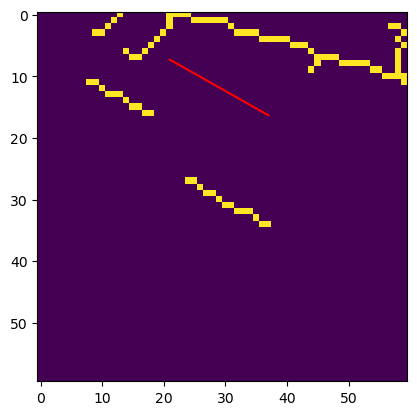

In [20]:
crop_win = 30
cropx = np.arange(30 - np.abs(0.5*l*np.cos(theta)), np.abs(30 + 0.5*l*np.cos(theta))).astype(int)
cropy = (np.tan(theta)*(cropx) - 0.5*l*np.sin(theta))# - np.tan(theta)*(crop_win)).astype(int)

plt.imshow(im_max[int(yc-crop_win) : int(yc+crop_win), int(xc-crop_win) : int(xc+crop_win)], vmin=0, vmax=1)
plt.plot(cropx, cropy, color='r')
#plt.plot(np.arrange(30), (np.tan(theta)*(xvals-30) + (30 - np.tan(theta)*(xc-30))).astype(int), color='r', lw=1)

Make a Movie

In [21]:
mykymo = []
for im in im_stack:
    ls=[]
    for i in range(len(xvals)):
        ls.append(im[test_line[i], xvals[i]])
    mykymo.append(ls)
mykymo = np.array(mykymo)

In [22]:
np.shape(np.zeros((len(im_stack), len(test_line))))

(100, 17)

In [23]:
mykymo = np.zeros((len(im_stack), len(test_line))) 
for index, im in enumerate(im_stack):
    ls=[]
    for i in range(len(xvals)):
        ls.append(im[test_line[i], xvals[i]])
    ls=np.array(ls)
    mykymo[index]+= ls

Text(0, 0.5, 'time (s)')

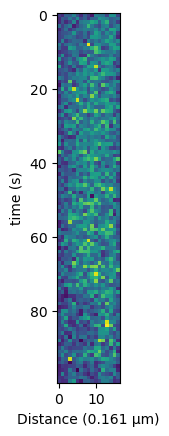

In [24]:
plt.imshow(mykymo)
plt.xlabel('Distance (0.161 µm)')
plt.ylabel('time (s)')

In [25]:
def kymo_func(kymo, sigma, mask_size, pixel_size):
    
    #Create a gaussian blur
    gauss = sf.gaussian(kymo, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu

    #Mask/Block
    mask_size=mask_size
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    #Extract properties
    im_relabel = measure.label(im_closed)
    im_props = measure.regionprops_table(im_relabel, kymo,
                                        properties=['area', 'major_axis_length',
                                                    'minor_axis_length','centroid',
                                                    'orientation', 'eccentricity',
                                                    'label', 'perimeter'])
    _df = pd.DataFrame(im_props)
    df_mt = _df.loc[_df['area'] == np.max(_df['area'])].reset_index()

    # Create test line
    xvals = np.arange(0, np.shape(kymo)[1])
    index = 0
    xc =  df_mt.loc[index, 'centroid-1']
    yc =  df_mt.loc[index, 'centroid-0']
    l =  df_mt.loc[index, 'major_axis_length']
    theta = -df_mt.loc[index, 'orientation'] + (np.pi/2)

    test_line = np.tan(theta)*xvals + (yc - np.tan(theta)*xc)

    plt.imshow(kymo)
    plt.plot(xvals, test_line, color='r')
    plt.title('slope = ' + str(round(np.abs(pixel_size / np.tan(theta))*1000)) + 'nm/s')
#     fig, ax  = plt.subplots(1,4, figsize = (8,8))

#     ax[0].imshow(kymo)
#     ax[0].plot(xvals, test_line, color='r')
#     ax[0].scatter(xc, yc, color = 'r')

#     ax[1].imshow(gauss)
#     ax[1].plot(xvals, test_line, color='r')
#     ax[1].scatter(xc, yc, color = 'r')

#     ax[2].imshow(im_thresh)
#     ax[2].plot(xvals, test_line, color='r')
#     ax[2].scatter(xc, yc, color = 'r')

#     ax[3].imshow(im_closed)
#     ax[3].plot(xvals, test_line, color='r')
#     ax[3].scatter(xc, yc, color = 'r')

    return np.abs(pixel_size / np.tan(theta))*1000 #nm/s

In [28]:
kymo_func(mykymo, sigma = 1, mask_size=3, pixel_size = pixel_size)

1.4820419560476856

In [27]:
def kymo_func(kymo, sigma, mask_size, pixel_size):

    #Create a gaussian blur
    gauss = sf.gaussian(kymo, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu

    #Mask/Block
    mask_size=mask_size
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    #Extract properties
    im_relabel = measure.label(im_closed)
    im_props = measure.regionprops_table(im_relabel, kymo,
                                        properties=['area', 'major_axis_length',
                                                    'minor_axis_length','centroid',
                                                    'orientation', 'eccentricity',
                                                    'label', 'perimeter'])
    _df = pd.DataFrame(im_props)
    df_mt = _df.loc[_df['area'] == np.max(_df['area'])].reset_index()

    # Create test line
    xvals = np.arange(0, np.shape(kymo)[1])
    index = 0
    xc =  df_mt.loc[index, 'centroid-1']
    yc =  df_mt.loc[index, 'centroid-0']
    l =  df_mt.loc[index, 'major_axis_length']
    theta = -df_mt.loc[index, 'orientation'] + (np.pi/2)

    test_line = np.tan(theta)*xvals + (yc - np.tan(theta)*xc)


#     fig, ax  = plt.subplots(1,4, figsize = (8,8))

#     ax[0].imshow(kymo)
#     ax[0].plot(xvals, test_line, color='r')
#     ax[0].scatter(xc, yc, color = 'r')

#     ax[1].imshow(gauss)
#     ax[1].plot(xvals, test_line, color='r')
#     ax[1].scatter(xc, yc, color = 'r')

#     ax[2].imshow(im_thresh)
#     ax[2].plot(xvals, test_line, color='r')
#     ax[2].scatter(xc, yc, color = 'r')

#     ax[3].imshow(im_closed)
#     ax[3].plot(xvals, test_line, color='r')
#     ax[3].scatter(xc, yc, color = 'r')
    
#     print(np.abs(pixel_size / np.tan(theta))*1000)
    return np.abs(pixel_size / np.tan(theta))*1000 #nm/s

In [158]:
np.shape(im_max)

(512, 512)

In [186]:
speeds=[]
for i in range(len(df_max['label'])):
    xc =  df_max.loc[i, 'centroid-1']
    yc =  df_max.loc[i, 'centroid-0']
    l =  df_max.loc[i, 'major_axis_length']
    theta = -df_max.loc[i, 'orientation'] + (np.pi/2)
    
    xvals = np.arange(xc - np.abs(0.5*l*np.cos(theta)), xc + np.abs(0.5*l*np.cos(theta))).astype(int)
    if len(xvals)==0:
        speeds.append(0)
        print(i)
    else:
        test_line = (np.tan(theta)*xvals + (yc - np.tan(theta)*xc)).astype(int)

        mykymo = []
        for im in im_stack:
            ls=[]
            for i in range(len(xvals)):
                ls.append(im[test_line[i], xvals[i]])
            mykymo.append(ls)
        mykymo = np.array(mykymo)

        speeds.append(kymo_func(mykymo, sigma = 1, mask_size=3, pixel_size = pixel_size))

speeds = np.array(speeds)

130


In [191]:
speeds.max()

170.64579562844577

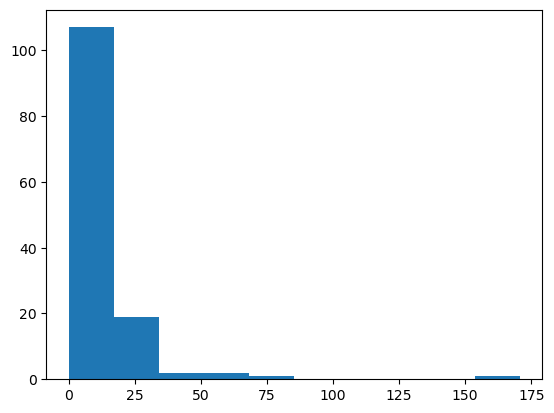

In [201]:
plt.hist(speeds);

# 1410 Try it 

In [202]:
pixel_size = 0.161 #um/pixel

#Import Stack
file_path = '../../data/gliding/'
file_folder = '2023-03-23_Gliding/2023-Mar23_AnaGliding_Ncd-cherry-freshMT488_lowATPload_min_2/images/'
included_frames = '*2023*.tif'
im_dir = file_path+file_folder+included_frames

im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

#Import Background
bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg_im = skimage.io.imread(im_dir).astype(np.int16)
bg_avg = np.average(bg_im)

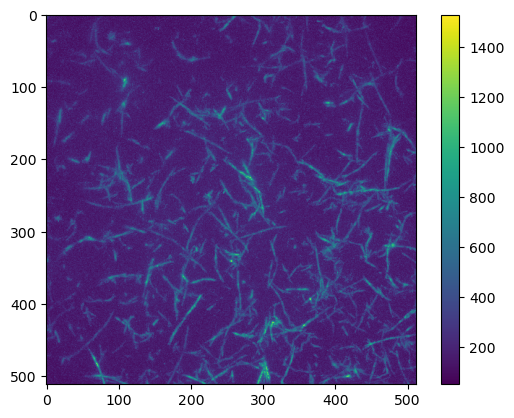

In [203]:
#Create a maximum projection image -- create a single image where each pixel value is the maximum intensity for that pixel across all images in the stack
max_proj = np.amax(im_stack-bg_avg, axis=0)
plt.imshow(max_proj)
plt.colorbar()

# - end - 

In [21]:
bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg_im = skimage.io.imread(im_dir).astype(np.int16)
bg_avg = np.average(bg_im)

In [4]:
#Import stack
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/images/'
included_frames = '*2023*.tif'
im_dir = file_path+file_folder+included_frames

im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

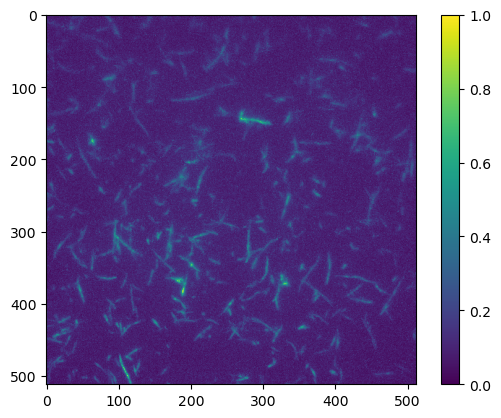

In [16]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/'
included_frames = 'MAX_2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1_MMStack_Pos0.ome.tif'
im_dir = file_path+file_folder+included_frames
max_proj = skimage.io.imread(im_dir).astype(np.int16)
max_proj_norm = (max_proj - max_proj.min()) / (max_proj.max() - max_proj.min())
plt.imshow(max_proj_norm)
plt.colorbar()

# Single Kymograph Analysis

In [64]:
def kymo_func(im_dir, bg_im_dir, sigma, mask_size, pixel_size):

    #Read in images
    kymo = skimage.io.imread(im_dir).astype(np.int16)
    bg = skimage.io.imread(bg_im_dir).astype(np.int16)
    
    #Subtract camera noise
    bg_avg = np.average(bg)
    kymo_bs = kymo - bg_avg
    
    #Create a gaussian blur
    gauss = sf.gaussian(kymo_bs, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu

    #Mask/Block
    mask_size=mask_size
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    #Extract properties
    im_relabel = measure.label(im_closed)
    im_props = measure.regionprops_table(im_relabel, kymo,
                                        properties=['area', 'major_axis_length',
                                                    'minor_axis_length','centroid',
                                                    'orientation', 'eccentricity',
                                                    'label', 'perimeter'])
    _df = pd.DataFrame(im_props)
    df_mt = _df.loc[_df['area'] == np.max(_df['area'])].reset_index()

    # Create test line
    xvals = np.arange(0, np.shape(kymo)[1])
    index = 0
    xc =  df_mt.loc[index, 'centroid-1']
    yc =  df_mt.loc[index, 'centroid-0']
    l =  df_mt.loc[index, 'major_axis_length']
    theta = -df_mt.loc[index, 'orientation'] + (np.pi/2)

    test_line = np.tan(theta)*xvals + (yc - np.tan(theta)*xc)


#     fig, ax  = plt.subplots(1,4, figsize = (8,8))

#     ax[0].imshow(kymo_bs)
#     ax[0].plot(xvals, test_line, color='r')
#     ax[0].scatter(xc, yc, color = 'r')

#     ax[1].imshow(gauss)
#     ax[1].plot(xvals, test_line, color='r')
#     ax[1].scatter(xc, yc, color = 'r')

#     ax[2].imshow(im_thresh)
#     ax[2].plot(xvals, test_line, color='r')
#     ax[2].scatter(xc, yc, color = 'r')

#     ax[3].imshow(im_closed)
#     ax[3].plot(xvals, test_line, color='r')
#     ax[3].scatter(xc, yc, color = 'r')

    return np.abs(pixel_size / np.tan(theta))*1000 #nm/s

In [294]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/kymo/'
included_frames = 'W44H1X350Y178.tif'
im_dir = file_path+file_folder+included_frames

bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames

pixel_size = pixel_size = 0.161 # µm per pixel

kymo_func(im_dir, bg_im_dir, sigma = 1, mask_size=3, pixel_size = pixel_size)

TypeError: kymo_func() got multiple values for argument 'sigma'

## Test im

In [221]:
def kymo_func(kymo, sigma, mask_size, pixel_size):

    #Create a gaussian blur
    gauss = sf.gaussian(kymo, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu

    #Mask/Block
    mask_size=mask_size
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    #Extract properties
    im_relabel = measure.label(im_closed)
    im_props = measure.regionprops_table(im_relabel, kymo,
                                        properties=['area', 'major_axis_length',
                                                    'minor_axis_length','centroid',
                                                    'orientation', 'eccentricity',
                                                    'label', 'perimeter'])
    _df = pd.DataFrame(im_props)
    df_mt = _df.loc[_df['area'] == np.max(_df['area'])].reset_index()

    # Create test line
    xvals = np.arange(0, np.shape(kymo)[1])
    index = 0
    xc =  df_mt.loc[index, 'centroid-1']
    yc =  df_mt.loc[index, 'centroid-0']
    l =  df_mt.loc[index, 'major_axis_length']
    theta = -df_mt.loc[index, 'orientation'] + (np.pi/2)

    test_line = np.tan(theta)*xvals + (yc - np.tan(theta)*xc)


    fig, ax  = plt.subplots(4, figsize = (8,3))

    ax[0].imshow(kymo)
    ax[0].plot(xvals, test_line, color='r')
    ax[0].scatter(xc, yc, color = 'r')

    ax[1].imshow(gauss)
    ax[1].plot(xvals, test_line, color='r')
    ax[1].scatter(xc, yc, color = 'r')

    ax[2].imshow(im_thresh)
    ax[2].plot(xvals, test_line, color='r')
    ax[2].scatter(xc, yc, color = 'r')

    ax[3].imshow(im_closed)
    ax[3].plot(xvals, test_line, color='r')
    ax[3].scatter(xc, yc, color = 'r')

    print(str(np.abs(pixel_size / np.tan(theta))*1000) + ' nm/s')

4307.4051923649795 nm/s


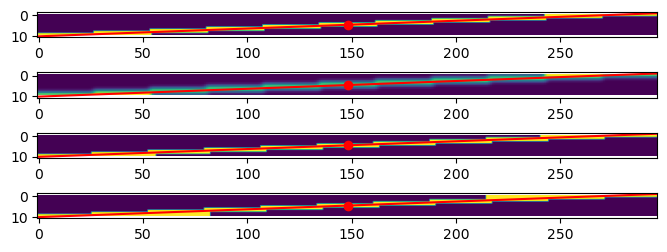

In [104]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/gliding/'
file_folder = 'kymo-example/'
included_frames = 'multikymo.tif'
im_dir = file_path+file_folder+included_frames

pixel_size = pixel_size = 0.161 # µm per pixel

kymo_func(im_dir, sigma = 1, mask_size=3, pixel_size = pixel_size)

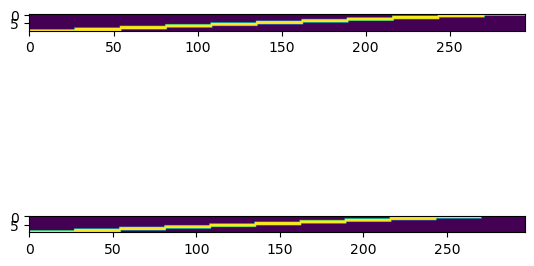

In [106]:
#compare fiji kymos:
#kymo builder plugin
#Choose the experiment file name:
file_path = '../../data/gliding/'
file_folder = 'kymo-example/'
included_frames = 'kymobuilder.tif'
im_dir = file_path+file_folder+included_frames
kymobuild = skimage.io.imread(im_dir).astype(np.int16)

#multi kymo
#Choose the experiment file name:
file_path = '../../data/gliding/'
file_folder = 'kymo-example/'
included_frames = 'multikymo.tif'
im_dir = file_path+file_folder+included_frames
multikymo = skimage.io.imread(im_dir).astype(np.int16)

fig,ax=plt.subplots(2)
ax[0].imshow(kymobuild)
ax[1].imshow(multikymo)

In [116]:
np.unique(multikymo[:,1:-1])

array([  0, 255], dtype=int16)

In [115]:
np.where((multikymo[:,1:-1]==kymobuild) == False)

(array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9]),
 array([242, 215, 270, 188, 243, 161, 216, 134, 189, 107, 162,  80, 135,
         53, 108,  26,  81,  54]))

In [117]:
np.unique(kymobuild)

array([  0, 255], dtype=int16)

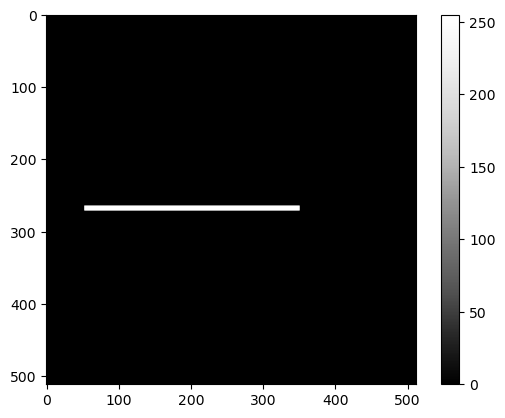

In [118]:
#Import the Max Proj

#Choose the experiment file name:
file_path = '../../data/gliding/'
file_folder = 'kymo-example/'
included_frames = 'MAX_kymo-exstack.tif'
im_dir = file_path+file_folder+included_frames
max_proj = skimage.io.imread(im_dir).astype(np.int16)

plt.imshow(max_proj, cmap = 'Greys_r')
plt.colorbar()

In [119]:
np.unique(max_proj)

array([  0, 255], dtype=int16)

In [59]:
np.where(max_proj==255)

(array([265, 265, 265, ..., 271, 271, 271]),
 array([ 53,  54,  55, ..., 348, 349, 350]))

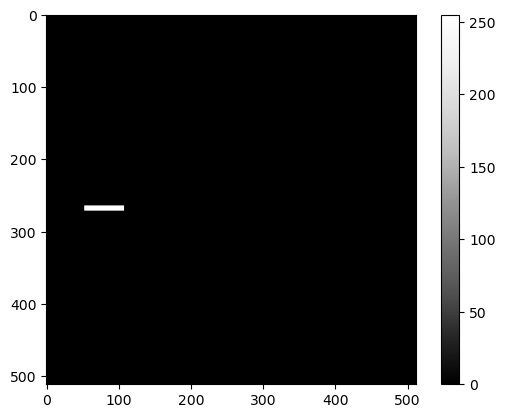

In [200]:
#Import stack of image
#Choose the experiment file name:
file_path = '../../data/gliding/'
file_folder = 'kymo-example/images/'
included_frames = '*images*.tif'
im_dir = file_path+file_folder+included_frames
stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    stack.append(skimage.io.imread(file).astype(np.int16))
stack = np.array(stack)

plt.imshow(stack[0], cmap='Greys_r')
plt.colorbar()

In [201]:
stack_norm = []
for im in stack:
    norm = (im - im.min()) / (im.max() - im.min())
    stack_norm.append(norm)
stack_norm = np.array(stack_norm)

In [202]:
np.unique(np.sum(stack_norm, axis=0))

array([0., 1., 2., 3.])

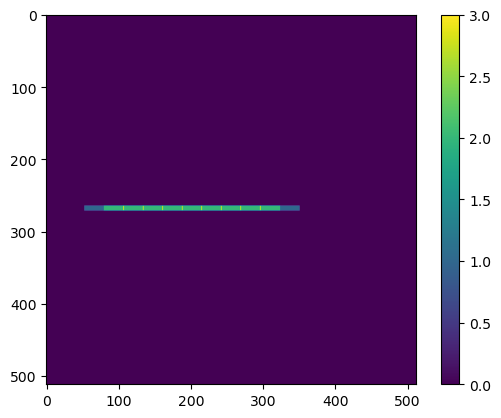

In [203]:
#make max_proj
max_im = np.sum(stack_norm, axis=0)
plt.imshow(max_im, vmin=0, vmax=3)
plt.colorbar()

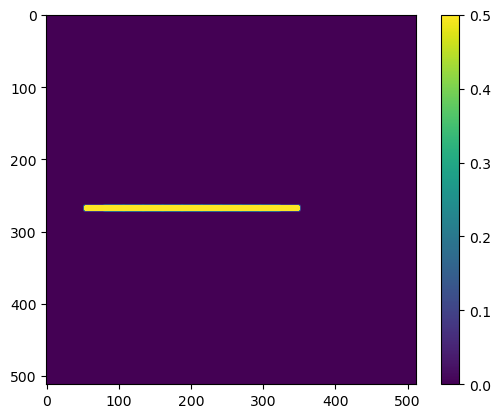

In [204]:
block_size = 3
thresh_niblack = filters.threshold_niblack(max_im, window_size=block_size, k=0.001)
plt.imshow(thresh_niblack, vmin=0, vmax=0.5)
plt.colorbar()

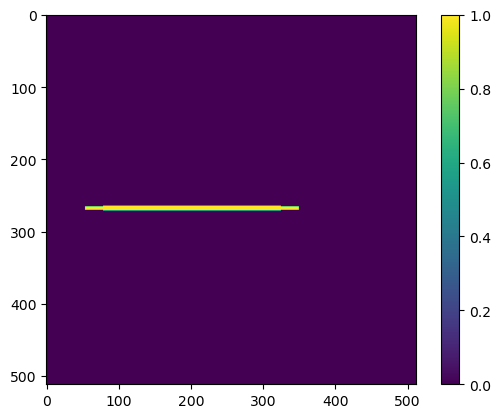

In [205]:
thresh_otsu = filters.threshold_otsu(thresh_niblack)
im_thresh = (thresh_niblack > thresh_otsu)
plt.imshow(im_thresh)
plt.colorbar()

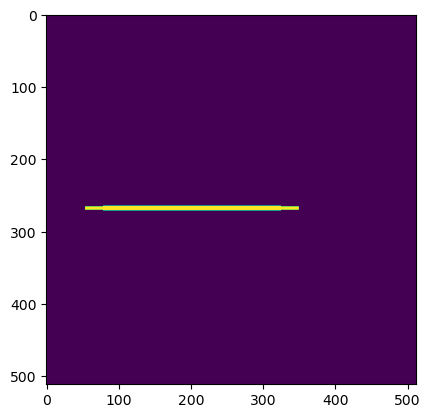

In [206]:
mask_size=1
mask = morphology.square(mask_size)
im_closed = morphology.closing(im_thresh, selem=mask)
plt.imshow(im_closed)

number of regions = 1


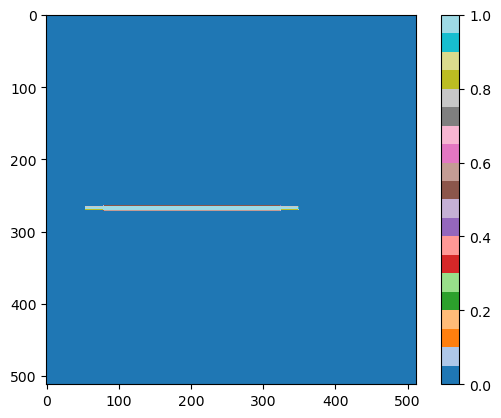

In [207]:
im_filtered = im_closed.copy()
im_label, n_labels = measure.label(im_filtered, return_num=True)
print('number of regions = ' + str(n_labels))
plt.imshow(im_label, cmap = 'tab20')
plt.colorbar();

In [208]:
unique_regions, region_counts = np.unique(im_label, return_counts=True)
# Create dictionary except for 0 (background)
dict_area = dict(zip(unique_regions,region_counts))

#Remove small regions
area_thresh=10
im_sized = np.copy(im_label)
for label in unique_regions:
    if label > 0 and dict_area[label]<=area_thresh:
        im_sized[im_sized==label] = 0

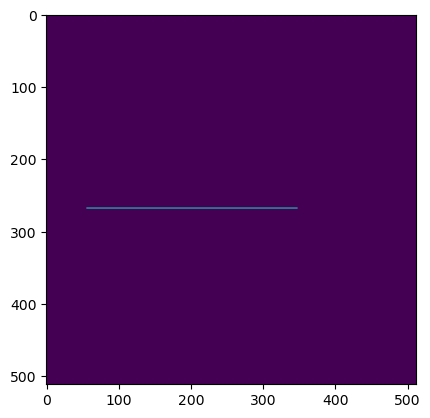

In [209]:
im_thinned = morphology.thin(im_sized)
im_relabel = measure.label(im_thinned)
plt.imshow(im_thinned)

In [210]:
min_dist=9
min_angle=75
padding=3
im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                    min_angle=min_angle, padding=padding)

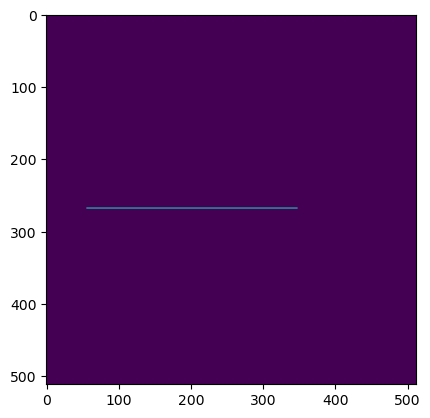

In [211]:
plt.imshow(im_noxovers)

In [212]:
im_props = measure.regionprops_table(im_noxovers, max_im,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
_df = pd.DataFrame(im_props)

In [213]:
_df

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter
0,292,337.17058,0.0,268.0,201.5,1.570796,1.0,1,290.0


In [215]:
max_im[test_line[200], xvals[200]]

2.0

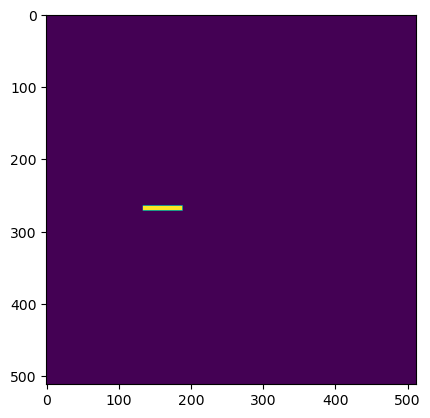

In [216]:
plt.imshow(stack[3])

(10, 338)

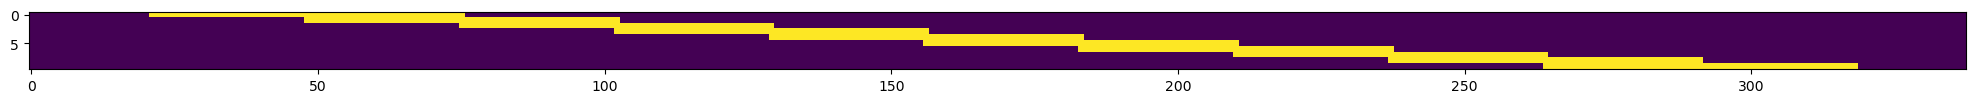

In [218]:
# plt.imshow(max_im[200:300, 0:500])
stack[0][test_line[0]:test_line[-1], xvals[0]:xvals[-1]]
mykymo = []
for im in stack:
    ls=[]
    for i in range(len(xvals)):
        ls.append(im[test_line[i], xvals[i]])
    mykymo.append(ls)
mykymo = np.array(mykymo)
fig,ax=plt.subplots(figsize=(25,8))
plt.imshow(mykymo)
np.shape(mykymo)

4312.047746513252 nm/s


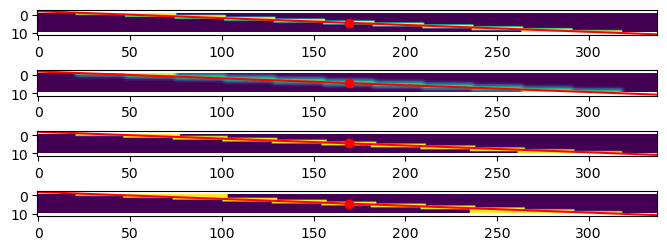

In [222]:
kymo_func(mykymo, sigma = 1, mask_size=3, pixel_size = pixel_size)

In [219]:
np.shape(kymobuild)

(10, 295)

In [182]:
testls==max_im[test_line[0], xvals[0]:xvals[-1]+1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# Segment Max Proj

In [204]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/'
included_frames = 'MAX_2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1_MMStack_Pos0.ome.tif'
im_dir = file_path+file_folder+included_frames
max_proj = skimage.io.imread(im_dir).astype(np.int16)

#camera background
bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg = skimage.io.imread(bg_im_dir).astype(np.int16)
bg_avg = np.average(bg)


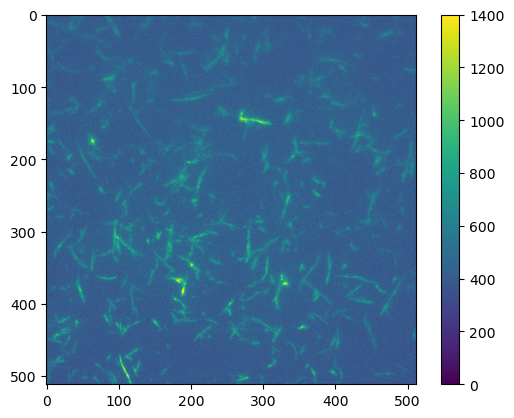

In [205]:
plt.imshow(max_proj, vmin = 0, vmax=1400)
plt.colorbar()

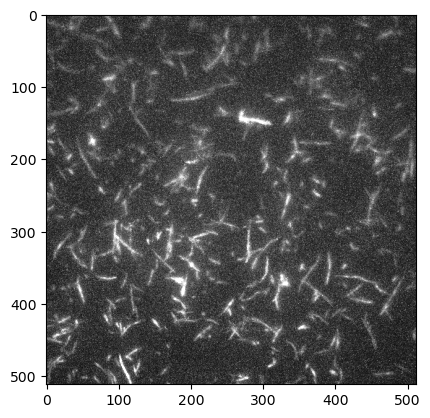

In [207]:
image_norm = (max_proj - max_proj.min()) / (max_proj.max() - max_proj.min())
plt.imshow(image_norm, vmin=0, vmax=0.5, cmap='Greys_r')
#plt.colorbar()

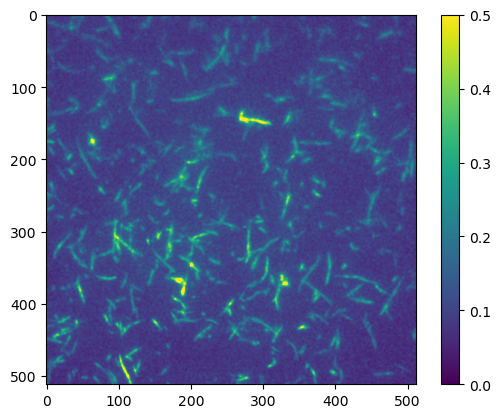

In [98]:
block_size = 3
thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size, k=0.001)
plt.imshow(thresh_niblack, vmin=0, vmax=0.5)
plt.colorbar()

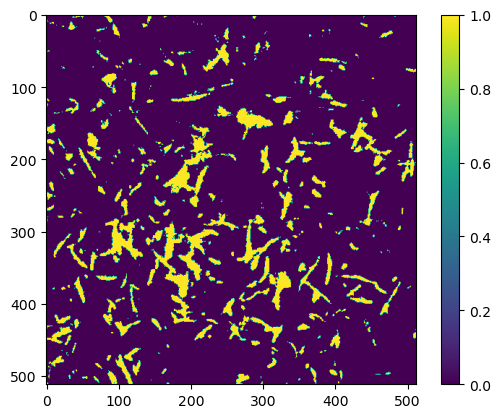

In [99]:
thresh_otsu = filters.threshold_otsu(thresh_niblack)
im_thresh = (thresh_niblack > thresh_otsu)
plt.imshow(im_thresh)
plt.colorbar()

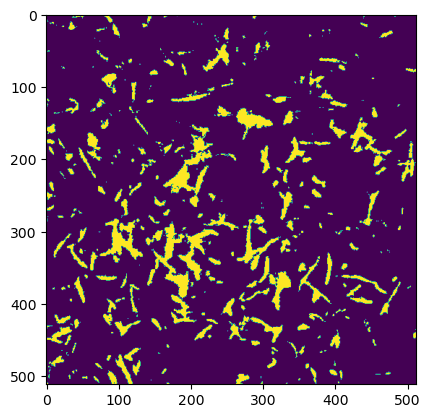

In [100]:
mask_size=1
mask = morphology.square(mask_size)
im_closed = morphology.closing(im_thresh, selem=mask)
plt.imshow(im_closed)

In [101]:
im_filtered = im_closed.copy()

number of regions = 449


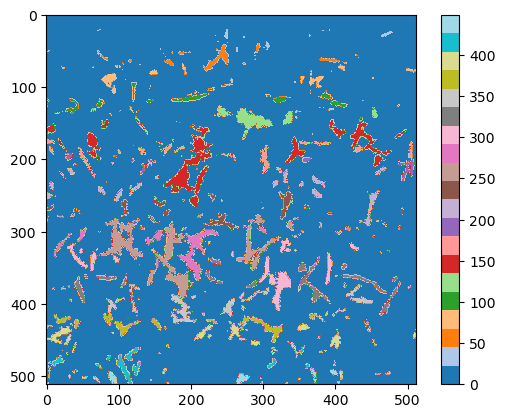

In [102]:
im_label, n_labels = measure.label(im_filtered, return_num=True)
print('number of regions = ' + str(n_labels))
plt.imshow(im_label, cmap = 'tab20')
plt.colorbar();

In [103]:
unique_regions, region_counts = np.unique(im_label, return_counts=True)

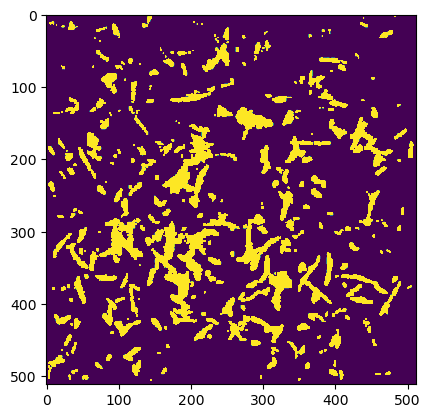

In [105]:
im_border = np.copy(im_label)
edge=3
border = np.ones(np.shape(im_label))
border[edge:-1*edge,edge:-1*edge] -= 1

for n in np.unique(im_border):
    if np.any(border * [im_border==n+1]):
        im_border[im_border==n+1] = 0

im_internal=im_border
plt.imshow(im_border, vmin=0, vmax=1)

In [106]:
# Create dictionary except for 0 (background)
dict_area = dict(zip(unique_regions,region_counts))

#Remove small regions
area_thresh=10
im_sized = np.copy(im_internal)
for label in unique_regions:
    if label > 0 and dict_area[label]<=area_thresh:
        im_sized[im_sized==label] = 0

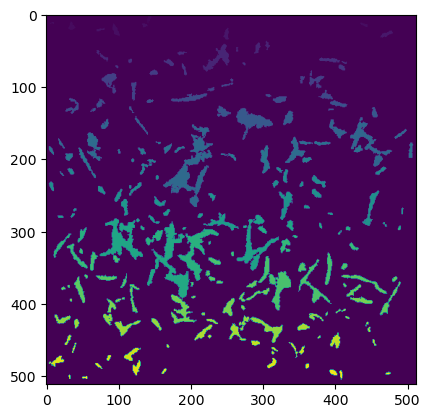

In [107]:
plt.imshow(im_sized)

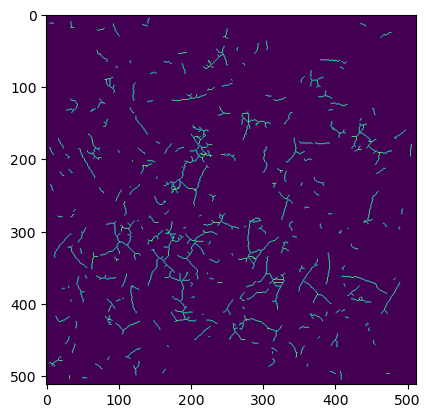

In [108]:
im_thinned = morphology.thin(im_sized)
im_relabel = measure.label(im_thinned)
plt.imshow(im_thinned)

In [109]:
min_dist=9
min_angle=75
padding=3
im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                    min_angle=min_angle, padding=padding)

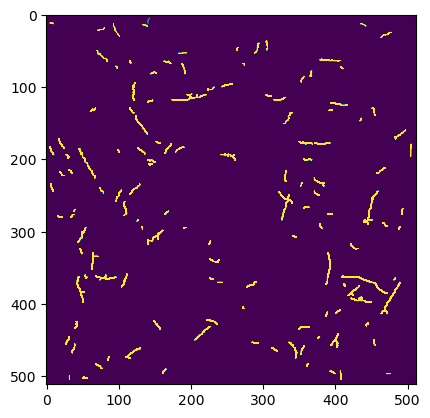

In [110]:
plt.imshow(im_noxovers, vmin=0, vmax = 1)

In [111]:
im_props = measure.regionprops_table(im_noxovers, max_proj,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
_df = pd.DataFrame(im_props)

In [112]:
_df

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter
0,8,9.652881,2.138198,8.500000,141.125000,-0.327676,0.975158,1,7.242641
1,6,6.902545,1.115241,12.166667,7.500000,1.425068,0.986861,3,4.207107
2,18,22.948041,2.109301,21.500000,95.944444,0.443006,0.995767,4,19.106602
3,8,10.026790,1.101585,14.125000,438.500000,1.150496,0.993947,5,7.035534
4,8,9.536478,1.027419,15.000000,136.500000,1.289138,0.994180,6,6.828427
...,...,...,...,...,...,...,...,...,...
127,8,10.119406,1.160873,495.375000,396.500000,1.129917,0.993398,207,7.242641
128,12,13.870023,1.135399,499.500000,407.750000,0.094764,0.996644,208,10.414214
129,5,5.656854,0.000000,497.000000,473.000000,1.570796,1.000000,209,3.000000
130,5,5.656854,0.000000,502.000000,32.000000,0.000000,1.000000,210,3.000000


array([-15.        , -13.96551724, -12.93103448, -11.89655172,
       -10.86206897,  -9.82758621,  -8.79310345,  -7.75862069,
        -6.72413793,  -5.68965517,  -4.65517241,  -3.62068966,
        -2.5862069 ,  -1.55172414,  -0.51724138,   0.51724138,
         1.55172414,   2.5862069 ,   3.62068966,   4.65517241,
         5.68965517,   6.72413793,   7.75862069,   8.79310345,
         9.82758621,  10.86206897,  11.89655172,  12.93103448,
        13.96551724,  15.        ])

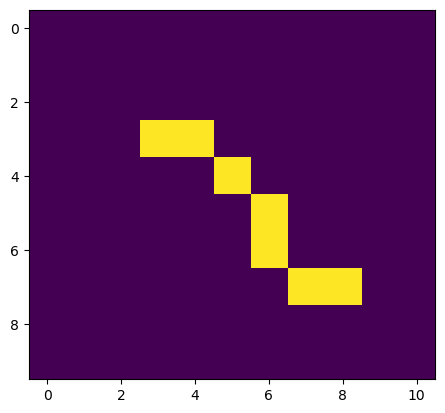

In [149]:
x,y = np.where(im_relabel==125)
mt_segment = im_relabel[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
plt.imshow(mt_segment)

min_dist=9
min_angle=75
padding=3

test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

_, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                          min_distance=min_dist,
                                          min_angle=min_angle, 
                                          num_peaks=2)  
# im_cleaned = max_proj.copy()

# for n in np.unique(max_proj)[1:]:
#     x,y = np.where(max_proj==n)
#     mt_segment = max_proj[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]

#     if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
#         im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

In [93]:
np.unique(im_eccen)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [107]:
im_eccen = im_label.copy()
im_props = measure.regionprops_table(im_eccen, properties=['label','eccentricity'])
df = pd.DataFrame(im_props)

eccen_thresh=0.90
for n in np.unique(im_eccen)[1:]:
    if df.loc[n-1, 'eccentricity'] < eccen_thresh:
        im_eccen[im_eccen==n] = 0

In [108]:
df[df['label']==n]['eccentricity'].values

array([0.81649658])

In [109]:
df.loc[n-1, 'eccentricity']

0.816496580927726

In [110]:
len(np.unique(im_eccen))

180

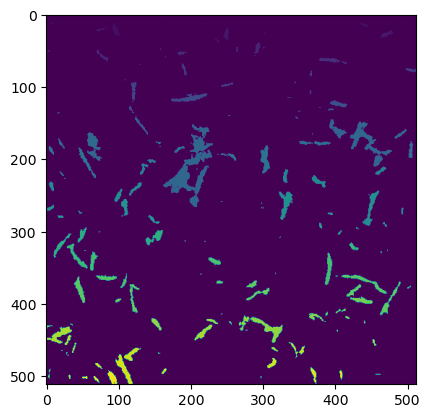

In [111]:
plt.imshow(im_eccen)

In [ ]:
x,y = np.where(max_proj==n)
mt_segment = max_proj[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]

In [114]:
test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)   

(512, 512)

In [ ]:
test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

In [113]:
min_dist=9
min_angle=75
padding=3

im_cleaned = max_proj.copy()

for n in np.unique(max_proj)[1:]:
    x,y = np.where(max_proj==n)
    mt_segment = max_proj[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]

    if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
        im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
plt.imwho(im_cleaned)

In [38]:
np.sum(_), np.shape(max_proj)[0]**2

(262144, 262144)

In [39]:
count_thresh=200
unique[-1] > count_thresh

True

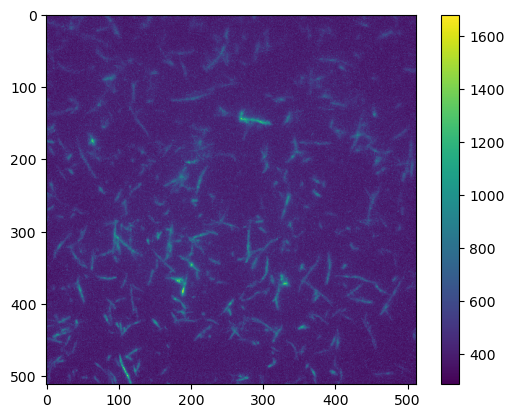

In [40]:
im_subt = max_proj - im_closed
plt.imshow(im_subt)
plt.colorbar()

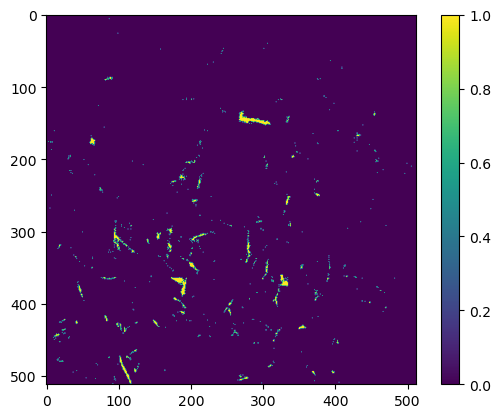

In [41]:
im_yen = filters.threshold_yen(im_subt)
im_filtered_yen = im_subt > im_yen
plt.imshow(im_filtered_yen)
plt.colorbar()

In [128]:
def filter_mts(image, block_size=5, mask_size=5, yen=False):
    """
    Image processing for individual MT image file. Images are first normalized
    before applying local thresholding to correct for nonuniform image background.
    Global thresholding is then performed to obtain the thresholded image of
    putative microtubules. Further processing is performed where small breaks
    in filaments are reconnected again.
    """
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered

def border_clear(im_label, edge=3):
    """
    Remove objects within `edge` pixels from the image boundary

    Input
    -------
    im_label : labeled image where objects in the image are assigned positive integer value
    edge : maximum number of pixels that putative filament needs to be away from the image boundary to be rejected
    """
    im_border = np.copy(im_label)

    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    return im_border

def determine_count_nums(im_label):
    """
    Obtains maximum number of objects in the labeled image. Used to determine
    if background subtraction and thresholding must be performed on top of Niblack
    thresholding scheme.
    """
    unique, counts = np.unique(im_label, return_counts=True)

    return unique, counts

def remove_small(im_label, area_thresh=10):
    im_sized = np.copy(im_label)

    unique, counts = determine_count_nums(im_label)

    # Create dictionary except for 0 (background)
    dict_area = dict(zip(unique,counts))

    for label in unique:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
    
    return im_sized

def remove_circulars(im_label, eccen_thresh=0.8):
    im_eccen = im_label.copy()

    im_props = measure.regionprops_table(im_eccen,
                                        properties=['label','eccentricity'])
    df = pd.DataFrame(im_props)

    for n in np.unique(im_eccen):
        if df[df['label']==n]['eccentricity'].values < eccen_thresh:
            im_eccen[im_eccen==n] = 0

    return im_eccen

def are2lines(mt_segment, min_dist=9, min_angle=75):
    """
    Determine if putative microtubules are two microtubules. Uses
    Hough straight lines to determine if there are at least 2
    lines that can be drawn from the putative filament.
    
    Input
    -------
    mt_segment : (M, N), ndarray; cropped region about the putative
                 microtubule
    min_angle : int, minimum angle (in degrees) separating lines (default 75)
    
    Return
    -------
    len(angles)==2 : bool, determines whether there is a crossover
    """
    test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

    return len(angles)==2

def remove_line_crossovers(image, min_dist=9, min_angle=75, padding=3):
    """
    Removes microtubules that cross over in the images. 
    Input
    -------
    image : (M, N), ndarray; image from which MT crossovers are removed
    min_angle : int, minimum angle (in degrees) separating lines (default 30)
    padding : int, padding around cropped MT segments

    Return
    -------
    im_cleaned : (M, N), ndarray; image with MT crossovers removed
    """
    im_cleaned = image.copy()

    for n in np.unique(image)[1:]:
        x,y = np.where(image==n)
        mt_segment = image[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
        
        if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
            im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

    return im_cleaned

def process_mt_images(image, block_size=3, mask_size=3, count_thresh=200, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size)
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    # Determine if Yen thresholding background subtraction is necessary
    unique, _ = determine_count_nums(im_label)
    if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)
    im_internal = border_clear(im_label, edge=edge)
    im_sized = remove_small(im_internal, area_thresh=area_thresh)
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)

    return im_noxovers

In [116]:
def maj_ax_eqn(array, xc, yc, l, theta):
    return np.tan(theta)*array + yc - 0.5*l*np.sin(theta)

In [134]:
df = _df[_df['area']==np.max(_df['area'])]

In [212]:
xvals = np.arange(0, np.shape(kymo)[1])
index = 31
xc =  _df.loc[index, 'centroid-1']
yc =  _df.loc[index, 'centroid-0']
l =  _df.loc[index, 'major_axis_length']
theta = -_df.loc[index, 'orientation'] + (np.pi/2)

test_line = np.tan(theta)*xvals + yc + 0.5*l*np.sin(theta)

-0.07068440424563083

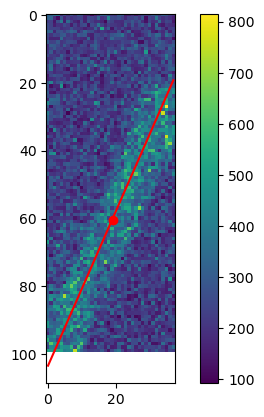

In [219]:
plt.imshow(kymo)
plt.colorbar()
plt.plot(xvals, test_line, color = 'r')
plt.scatter(xc, yc, color = 'r')

x1 = xc + np.cos(theta) * 0.5 * _df.loc[1, 'minor_axis_length']
y1 = yc - np.sin(theta) * 0.5 * _df.loc[1, 'minor_axis_length']
x2 = xc - np.sin(theta) * 0.5 * l
y2 = yc - np.cos(theta) * 0.5 * l
pixel_size / np.tan(theta)
# plt.plot((xc, x1), (yc, y1), 'w', linewidth=2.5)
# plt.plot((xc, x2), (yc, y2), 'k', linewidth=2.5)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 800x500 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Original'}>,
        <AxesSubplot:title={'center':'Isodata'}>,
        <AxesSubplot:title={'center':'Li'}>,
        <AxesSubplot:title={'center':'Mean'}>,
        <AxesSubplot:title={'center':'Minimum'}>,
        <AxesSubplot:title={'center':'Otsu'}>,
        <AxesSubplot:title={'center':'Triangle'}>,
        <AxesSubplot:title={'center':'Yen'}>], dtype=object))

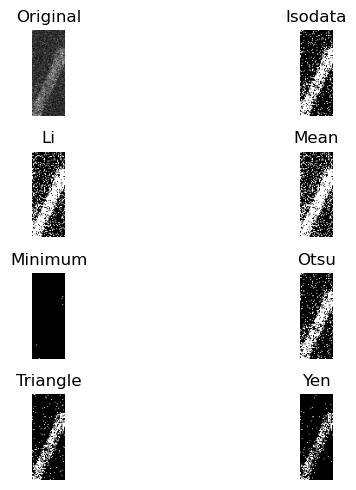

In [44]:
sf.try_all_threshold(kymo-bg_avg)

In [ ]:
def filter_mts(image, block_size=5, mask_size=5, yen=False):
    """
    Image processing for individual MT image file. Images are first normalized
    before applying local thresholding to correct for nonuniform image background.
    Global thresholding is then performed to obtain the thresholded image of
    putative microtubules. Further processing is performed where small breaks
    in filaments are reconnected again.
    """
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered